In [1]:
import os
import git
import sys

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

sys.path.append(git_root)

from abm_vec.one_period_sim import run_sim
from abm_vec.initialization import get_bank_data

from scipy.optimize import minimize
from scipy.stats import kstest
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from abm_vec.essentials.util import get_git_root_directory
import numpy as np
import random
from scipy import stats
from scipy.stats import anderson_ksamp

import statsmodels.api as sm
from scipy.stats import pearsonr
import pickle
import pandas as pd
from linearmodels import PanelOLS

In [2]:
bank_data = get_bank_data()

# Optimal parameters calculations

In [3]:
# define loss functions

def ks_test_error(empirical, simulated):
    return kstest(empirical, simulated, alternative='two-sided').statistic 

def mse_error(empirical, simulated):
    return np.average([(x-y)**2 for x,y in zip(empirical,simulated)])

def mae_error(empirical, simulated):
    return np.average([abs(x-y) for x,y in zip(empirical,simulated)])

def max_diff(empirical, simulated):
    return np.max([abs(x-y) for x,y in zip(empirical,simulated)])

def max_diff_percentage(empirical, simulated):
    return np.max([abs((x-y)/x) for x,y in zip(empirical,simulated)])

# TODO: maybe also person correlation maximization?

In [4]:
def parameter_calibration(x, error_function):
    param = {'firm_lb1': x[0],'firm_lb2': x[1],'firm_ub1': x[2], 'firm_ub2': x[3], 
             'firm_alpha1': x[4], 'firm_alpha2': x[5], 'firm_rho': x[6], 'min_productivity': x[7]}
    results = run_sim(param, copy.deepcopy(bank_data), [1]) 
    empirical_le_ratio = results[0]['banks']['bank_loans'] / results[0]['banks']['bank_equity']
    simulated_le_ratio = results[1]['banks']['bank_loans'] / results[0]['banks']['bank_equity']
    return error_function(empirical_le_ratio, simulated_le_ratio)

def le_ratio(x, random_seeds):
    param = {'firm_lb1': x[0],'firm_lb2': x[1],'firm_ub1': x[2], 'firm_ub2': x[3], 
             'firm_alpha1': x[4], 'firm_alpha2': x[5], 'firm_rho': x[6], 'min_productivity': x[7]}
    results = run_sim(param, copy.deepcopy(bank_data), random_seeds)
    if len(random_seeds) > 1:
        empirical_le_ratio = [s[0]['banks']['bank_loans'] / s[0]['banks']['bank_equity'] for s in results]
        simulated_le_ratio = [s[1]['banks']['bank_loans'] / s[0]['banks']['bank_equity'] for s in results]
    else:
        empirical_le_ratio = [results[0]['banks']['bank_loans'] / results[0]['banks']['bank_equity']]
        simulated_le_ratio = [results[1]['banks']['bank_loans'] / results[0]['banks']['bank_equity']]
    return empirical_le_ratio, simulated_le_ratio

In [ ]:
loss_functions = {
    "ks_test": ks_test_error,
    "mse": mse_error,
    "mae": mae_error,
    "max": max_diff
}

optimal_parameters = {
    "ks_test": None,
    "mse": None,
    "mae": None,
    "max": None
}

initial_guess = [10**6, 7500, 15 * 10 ** 7, 0.7 * 10 ** 6, 1.6, 1.7, 0.9, 150]
bounds = [(5 * 10 ** 5, 5 * 10 ** 6),
          (10 ** 3, 10**4),
          (5 * 10** 7, 30 * 10 ** 7),
          (5 * 10 ** 5, 10 ** 7),
          (0, 3),
          (0, 3),
          (0, 1) ,
          (100, 1000)]

for loss in optimal_parameters.keys():
    print(loss)
    min_fun = lambda x: parameter_calibration(x, loss_functions[loss])
    result = minimize(min_fun, initial_guess, method='Nelder-Mead', bounds=bounds)
    optimal_parameters[loss] = result.x

ks_test
mse


In [35]:
# save parameters
with open(os.path.join(os.getcwd(), "calibrated_parameters.pickle"), 'wb') as handle:
    pickle.dump(optimal_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Comparing the results 

In [5]:
with open(os.path.join(os.getcwd(), "calibrated_parameters.pickle"), 'rb') as handle:
    optimal_parameters = pickle.load(handle)

## simple linear regression with just one simulation run

In [50]:
ols_analysis = dict()
for loss in optimal_parameters.keys():
    print(loss)
    empirical_le_ratio, simulated_le_ratio = le_ratio(optimal_parameters[loss], [1])
    df = pd.DataFrame()
    df['empirical'] = empirical_le_ratio[0].tolist()
    df['simulated'] = simulated_le_ratio[0].tolist()
    ols_analysis[loss] = df

ks_test
mse
mae
max


In [72]:
for loss in optimal_parameters.keys():
    df = ols_analysis[loss]
    df['constant'] = 1
    result = sm.OLS(df['empirical'].values, df[['simulated']].values, hasconst=False).fit(cov_type='HC3', use_t=True)
    print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.844
Model:                            OLS   Adj. R-squared (uncentered):              0.842
Method:                 Least Squares   F-statistic:                              183.8
Date:                Thu, 11 Apr 2024   Prob (F-statistic):                    2.57e-22
Time:                        16:50:52   Log-Likelihood:                         -63.810
No. Observations:                  80   AIC:                                      129.6
Df Residuals:                      79   BIC:                                      132.0
Df Model:                           1                                                  
Covariance Type:                  HC3                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## multiple simulations

In [99]:
ols_analysis_multiple_df = dict()
ols_analysis_multiple_loss = dict()
random_seeds = random.sample(range(1, 100000), 1000)
for loss in optimal_parameters.keys():
    print(loss)
    empirical_le_ratio, simulated_le_ratio = le_ratio(optimal_parameters[loss], random_seeds)
    df = pd.DataFrame()
    ls = []
    for i in range(len(empirical_le_ratio)):
        df_temp = pd.DataFrame()
        df_temp['empirical'] = empirical_le_ratio[i].tolist()
        df_temp['simulated'] = simulated_le_ratio[i].tolist()
        df_temp['bank'] = list(range(len(df_temp)))
        df = pd.concat([df, df_temp])
        ls.append((empirical_le_ratio[i].tolist(), simulated_le_ratio[i].tolist()))
    ols_analysis_multiple[loss] = df
    ols_analysis_multiple_loss[loss] = ls

ks_test
mse
mae
max


In [119]:
# save parameters
with open(os.path.join(os.getcwd(), "calibration_runs.pickle"), 'wb') as handle:
    pickle.dump(ols_analysis_multiple_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [120]:
with open(os.path.join(os.getcwd(), "calibration_runs.pickle"), 'rb') as handle:
    ols_analysis_multiple_loss = pickle.load(handle)

In [100]:
# does not work
# for loss in optimal_parameters.keys():
#     print(loss)
#     df = ols_analysis_multiple[loss]
#     df = df.set_index('bank')
#     model = PanelOLS(df[['empirical']], df[['simulated']], entity_effects=True)
#     res = model.fit(cov_type='robust', debiased=True) #or # res = mod.fit(cov_type='clustered', cluster_entity=True)
#     print(res)

In [123]:
import matplotlib.pyplot as plt
labels = []
all_data_mae = []
all_data_mse = []
all_data_max_diff_percentage = []
for loss in list(ols_analysis_multiple_loss.keys()):
    labels.append(loss)
    data = ols_analysis_multiple_loss[loss]
    all_data_mse.append(np.array([mse_error(x[0],x[1]) for x in data]))
    all_data_mae.append(np.array([mae_error(x[0],x[1]) for x in data]))
    all_data_max_diff_percentage.append(np.array([max_diff_percentage(x[0],x[1]) for x in data]))

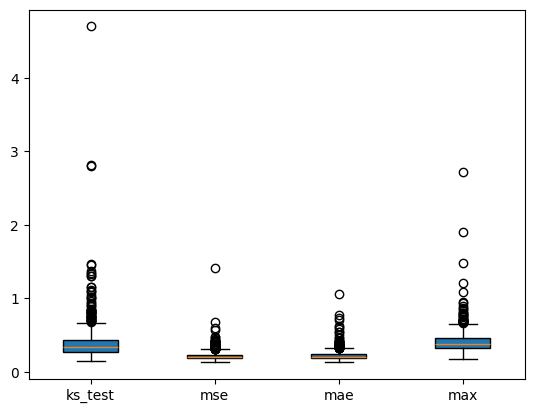

In [124]:
# mse
bplot1 = plt.boxplot(all_data_mse,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
plt.show()

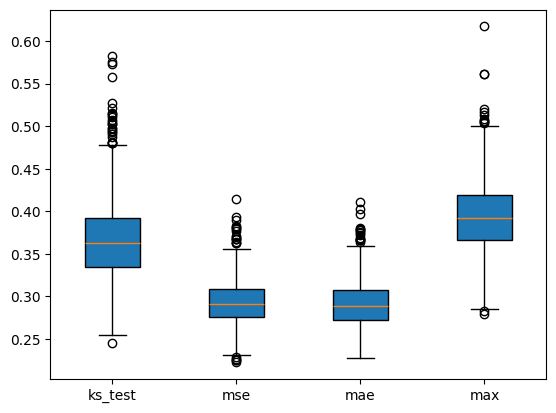

In [126]:
# mae
bplot1 = plt.boxplot(all_data_mae,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
plt.show()

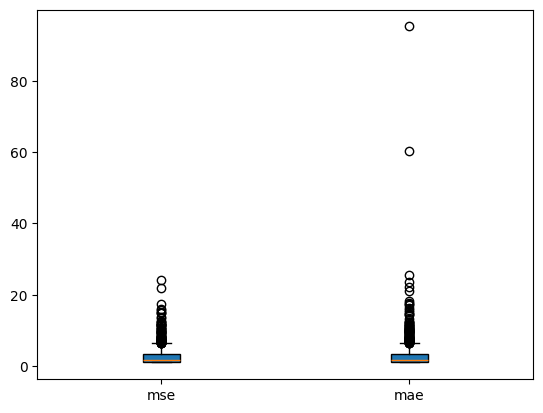

In [129]:
# percentage diff
bplot1 = plt.boxplot(all_data_max_diff_percentage[1:-1],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels[1:-1])  # will be used to label x-ticks
plt.show()

Mean squared error seems to be the qinner

# Running box plot

We display box plot with CI 

In [130]:
empirical_le_ratio, simulated_le_ratio = le_ratio(optimal_parameters['mse'], [1])

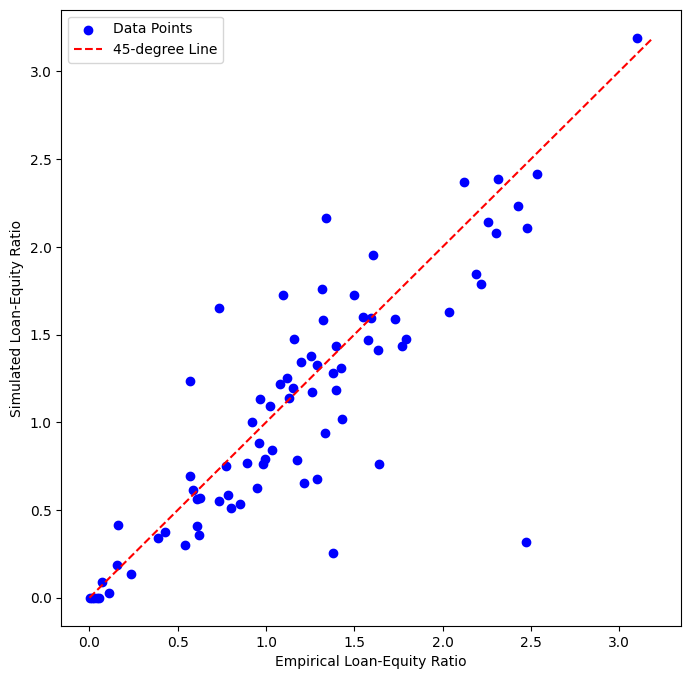

In [132]:
plt.figure(figsize=(8, 8))
plt.scatter(empirical_le_ratio[0], simulated_le_ratio[0], color='blue', label='Data Points')

# Plotting the 45-degree line for comparison
max_value = max(max(empirical_le_ratio[0]), max(simulated_le_ratio[0]))
plt.plot([0, max_value], [0, max_value], 'r--', label='45-degree Line')

# Adding labels and legend
plt.xlabel('Empirical Loan-Equity Ratio')
plt.ylabel('Simulated Loan-Equity Ratio')
plt.legend()
plt.show()

# Optimal parameters are the one from the MSE

In [6]:
optimal_x = optimal_parameters['mse']

# price optimization

In [7]:
def update_param(param, new):
    param_new = param.copy()
    param_new.update(new)
    return param_new

In [8]:
param = {'firm_lb1': optimal_x[0],
         'firm_lb2': optimal_x[1],
         'firm_ub1': optimal_x[2],
         'firm_ub2': optimal_x[3],
         'firm_alpha1': optimal_x[4],
         'firm_alpha2': optimal_x[5],
         'firm_rho': optimal_x[6],
         'min_productivity': optimal_x[7],
         'market_price': 600,
         "good_consumption": [0.98, 0.94],
         "good_consumption_std": [0.006, 0.006],
         "min_consumption": 0.9,
         "max_consumption": 1}

In [10]:
data = [run_sim(update_param(param, {'market_price': x}), copy.deepcopy(bank_data), [1]) for x in np.linspace(100, 1000, 100)]

In [11]:
min_prices_threshold = [res[1]['firms']['min_price_breach'] for res in data]

In [12]:
credit_demand = [len([x for x in res[1]["firms"]["firm_credit_demand"] if x>0]) for res in data]

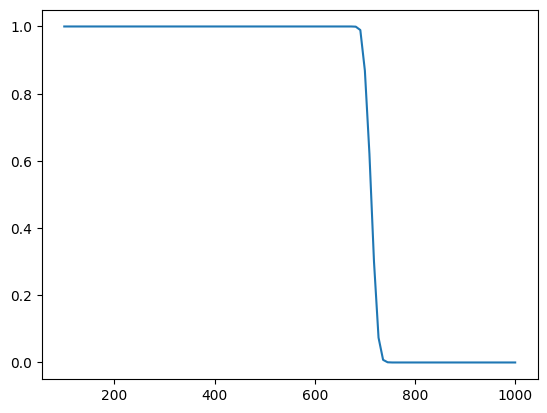

In [13]:
plt.plot(np.linspace(100, 1000, 100), min_prices_threshold)
plt.show()

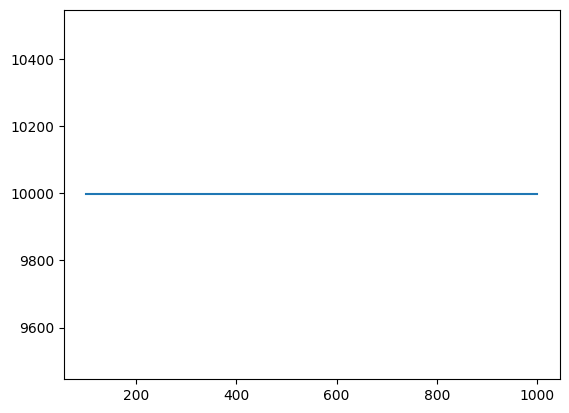

In [14]:
plt.plot(np.linspace(100, 1000, 100), credit_demand)
plt.show()

In [17]:
np.where(np.array(min_prices_threshold) < 1)

(array([64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
        81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
        98, 99]),)

In [19]:
min_prices_threshold[64:71]

[0.9994008388256441,
 0.9894148192530458,
 0.8685839824246055,
 0.6209306970241661,
 0.3005791891352107,
 0.07389654483722788,
 0.007789095266626723]

In [32]:
res = data[70]

(array([  11.,   41.,  301., 1127., 2453., 2821., 2090.,  932.,  200.,
          24.]),
 array([706.25749315, 711.8455689 , 717.43364465, 723.02172039,
        728.60979614, 734.19787189, 739.78594763, 745.37402338,
        750.96209913, 756.55017487, 762.13825062]),
 <BarContainer object of 10 artists>)

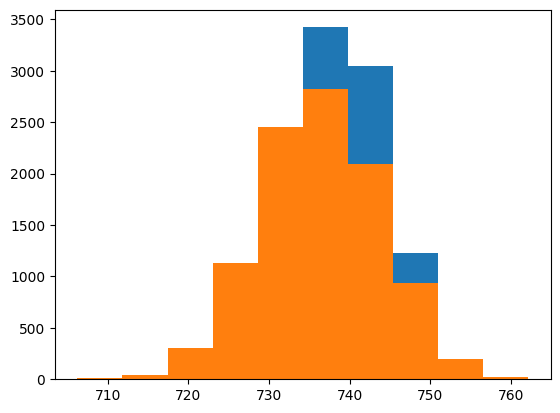

In [33]:
# price distribution 
plt.hist(res[1]['firms']['firm_price'])
plt.hist(res[0]['firms']['firm_price'])

In [34]:
np.linspace(100, 1000, 100)[66:71]

array([700.        , 709.09090909, 718.18181818, 727.27272727,
       736.36363636])

Anything from 700 onwards should be good 

# Setting $\mu_{goods}$

In [40]:
data = [run_sim(update_param(param, {'market_price': 750, 'good_consumption': [1, x], "min_consumption": 0.0}), 
                copy.deepcopy(bank_data), 
                [1]) for x in np.linspace(0.1, 1, 100)]

In [41]:
defaulting_firms = [len(res[1]['firms']["defaulting_firms"]) for res in data]
defaulting_banks = [len(res[1]['banks']['defaulted_banks']) for res in data]

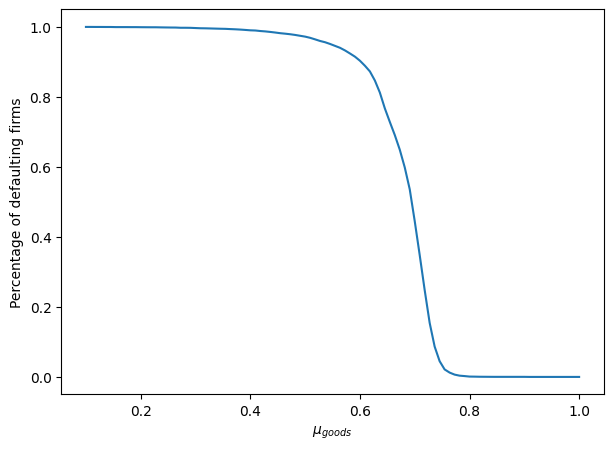

In [42]:
plt.figure(figsize=(7,5))
plt.plot(np.linspace(0.1, 1, 100), [x/10000 for x in defaulting_firms])
plt.xlabel('$\mu_{goods}$')
plt.ylabel('Percentage of defaulting firms')
plt.savefig(os.path.join(git_root, 'plots_presentation/percentage_firm_default.png'),bbox_inches='tight', dpi=400, edgecolor='white')
plt.show()

In [44]:
np.where(np.array([x/10000 for x in defaulting_firms]) < 0.05)

(array([71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
        88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),)

In [48]:
np.linspace(0.1, 1, 100)[71]

0.7454545454545454

In [49]:
np.array([x/10000 for x in defaulting_firms])[71]

0.0449

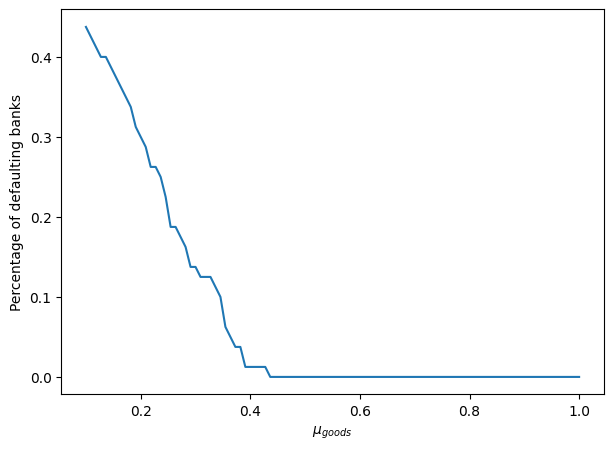

In [43]:
plt.figure(figsize=(7,5))
plt.plot(np.linspace(0.1, 1, 100), [x/80 for x in defaulting_banks])
plt.xlabel('$\mu_{goods}$')
plt.ylabel('Percentage of defaulting banks')
plt.savefig(os.path.join(git_root, 'plots_presentation/percentage_firm_default.png'),bbox_inches='tight', dpi=400, edgecolor='white')
plt.show()

# Check everything is good across a range of seeds

In [54]:
data = run_sim(update_param(param, {'market_price': 750, 'good_consumption': [1, 0.81], "min_consumption": 0.75}), 
                copy.deepcopy(bank_data), 
                random.sample(range(1, 100000), 1000))

In [55]:
defaulting_firms = [len(res[1]['firms']["defaulting_firms"]) for res in data]
defaulting_banks = [len(res[1]['banks']['defaulted_banks']) for res in data]

(array([ 25.,  87., 132., 203., 193., 159.,  93.,  65.,  23.,  20.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

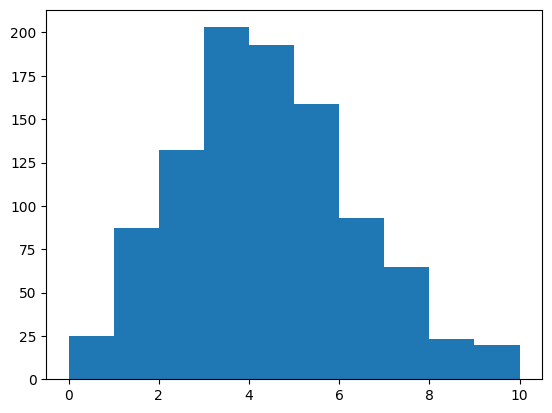

In [56]:
plt.hist(defaulting_firms)

(array([948.,   0.,   0.,   0.,   0.,  51.,   0.,   0.,   0.,   1.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

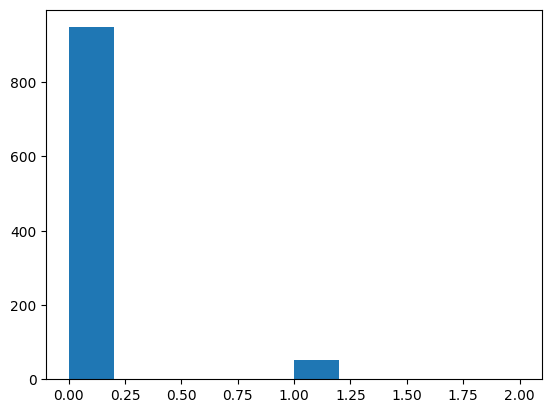

In [57]:
plt.hist(defaulting_banks)